# Toronto Bikeshare Data

[Bikeshare data source](https://open.toronto.ca/dataset/bike-share-toronto-ridership-data/)

## What the data looks like

This open dataset is an anonymized log of all bikeshare trips taken in Toronto. The fields include

* start time
* end time
* duration
* station A ID
* station B ID
* user type

The dataset is partitioned by quarters; each quarter a 3 month segment, starting from 1/1. I will be using the Q3 data from 2017 to 2019. By using only Q3 data, I will try to avoid seasonality and remove the effect from my model. Alternatively I could append a new column, denoting the seasonality. 

If I do incorporate seasonality, 

* I could use 2017 and training, 2018 as validation, and test on a sampling of 2019.
* Size of files could be an issue. I might have to subsample

If I don't,

* Focus solely on Q3 of each year.
* Let's start with that, and leave seasonality for future development

In [5]:
import pandas as pd
from pathlib import Path
import os

In [9]:
csv_path = Path.cwd().parent / 'data' / 'bikeshare-2017-q1.csv'
bikes = pd.read_csv(csv_path)

In [10]:
bikes.describe()

,trip_id,trip_duration_seconds,from_station_id,to_station_id
count,132123.000000,132123.000000,132123.000000,132123.000000
mean,790709.586393,677.281836,7072.742195,7071.681221
std,45224.004246,639.276795,58.620039,57.817939
min,712382.000000,60.000000,7000.000000,7000.000000
25%,751545.500000,372.000000,7027.000000,7027.000000
50%,790504.000000,559.000000,7056.000000,7056.000000
75%,829922.500000,830.000000,7113.000000,7107.000000
max,868705.000000,14386.000000,7216.000000,7216.000000


In [11]:
bikes.columns

Index(['trip_id', 'trip_start_time', 'trip_stop_time', 'trip_duration_seconds',
       'from_station_id', 'from_station_name', 'to_station_id',
       'to_station_name', 'user_type'],
      dtype='object')

In [12]:
members = sum(bikes['user_type'] == 'Member') / len(bikes['user_type'])
cash = 1. - members
print(f'membership %: {members:.4%}\ncasual %: {cash:.4%}')

membership %: 94.9971%
casual %: 5.0029%


Average member ride duration vs casual?

In [14]:
member_rides = bikes[bikes['user_type'] == 'Member']
cash_rides = bikes[bikes['user_type'] == 'Casual']
member_rides['trip_duration_seconds'].describe()

count    125513.000000
mean        623.792986
std         388.434959
min          60.000000
25%         365.000000
50%         545.000000
75%         800.000000
max       14071.000000
Name: trip_duration_seconds, dtype: float64

In [15]:
cash_rides['trip_duration_seconds'].describe()

count     6610.000000
mean      1692.946899
std       2053.883558
min         61.000000
25%        687.250000
50%       1065.000000
75%       1621.750000
max      14386.000000
Name: trip_duration_seconds, dtype: float64

Could we see the distribution? Perhaps in a violin plot?

In [16]:
from matplotlib import pyplot as plt

Text(0.5, 1.0, 'Casual rides')

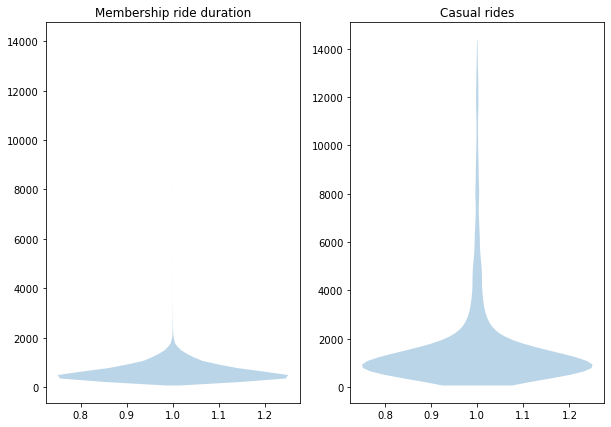

In [24]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,7))
axs[0].violinplot(
    dataset=member_rides['trip_duration_seconds'].values,
    showextrema=False)
axs[0].set_title('Membership ride duration')

axs[1].violinplot(
    dataset=cash_rides['trip_duration_seconds'].values,
    showextrema=False)
axs[1].set_title('Casual rides')

I think it's workable. Obviously casual rides have a significant tail skew but the bulge is not so significantly divergent from members that it's trivial to determine whether the rider is member or casual based solely on ride duration. I think we have a binary classification problem on our hands.

Model candidates:

* Logistic regression
* Random forest